In [1]:
import pandas as pd
from math import sqrt

from ProjectTools import OpenBeds

In [2]:
dry = True

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    nano_5mc_bed_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_5hmC_bed_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_5hmC_sub.bed'
    
    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_5mc(nano_5mc_bed_path))

    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(OpenBeds.get_nanopore_5hmc(nano_5hmC_bed_path))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    nano_5mc_bed_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_5hmC_bed_path = './data/prom_R10.4.1_E8.2_WGS_brain_5hmC.bed'

    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_5mc(nano_5mc_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(OpenBeds.get_nanopore_5hmc(nano_5hmC_bed_path))

In [3]:
from pybedtools import BedTool

ref_features = BedTool('./feature_references/mm39_fig4_features.bed')

mc_bed = BedTool.from_dataframe(pd.concat([nano_mc_df, wgbs_df]))
hmc_bed = BedTool.from_dataframe(pd.concat([tab_df, nano_hmc_df]))

In [4]:
def define_intergenic(mod_bed):
    df_of_non_intersects = BedTool.intersect(mod_bed, ref_features, v=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", "feature_type"])
    df_of_non_intersects["feature_type"] = "Intergenic"
    return df_of_non_intersects

def find_all_intersects(mod_bed):
    features_df = BedTool.intersect(mod_bed, ref_features, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", "dup1", "dup2", "dup3", "feature_name", "feature_type"])
    features_df.loc[features_df["feature_type"].str.contains("CpG"), "feature_type"] = "CGI"
    intergenic_df = define_intergenic(mod_bed)


    return pd.concat([features_df, intergenic_df]).drop(columns=["dup1", "dup2", "dup3"])

In [5]:
mc_intersects_df = find_all_intersects(mc_bed)
hmc_intersects_df = find_all_intersects(hmc_bed)

hmc_intersects_df.loc[hmc_intersects_df["method"] == "Nanopore 5hmC", "method"] = "Nanopore"
mc_intersects_df.loc[mc_intersects_df["method"] == "Nanopore 5mC", "method"] = "Nanopore"


In [6]:
from sklearn import preprocessing

mc_averages_df = mc_intersects_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index()
# mc_averages_df["binarised"] = preprocessing.binarize(mc_averages_df[["percentMeth"]].to_numpy())

hmc_averages_df = hmc_intersects_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index()
# hmc_averages_df["binarised"] = preprocessing.binarize(hmc_averages_df[["percentMeth"]].to_numpy())

In [7]:
mc_averages_df.loc[mc_averages_df["percentMeth"] > 0, "binarised"] = "5mC present"
mc_averages_df.loc[mc_averages_df["percentMeth"] == 0, "binarised"] = "5mC absent"

hmc_averages_df.loc[hmc_averages_df["percentMeth"] > 0, "binarised"] = "5hmC present"
hmc_averages_df.loc[hmc_averages_df["percentMeth"] == 0, "binarised"] = "5hmC absent"

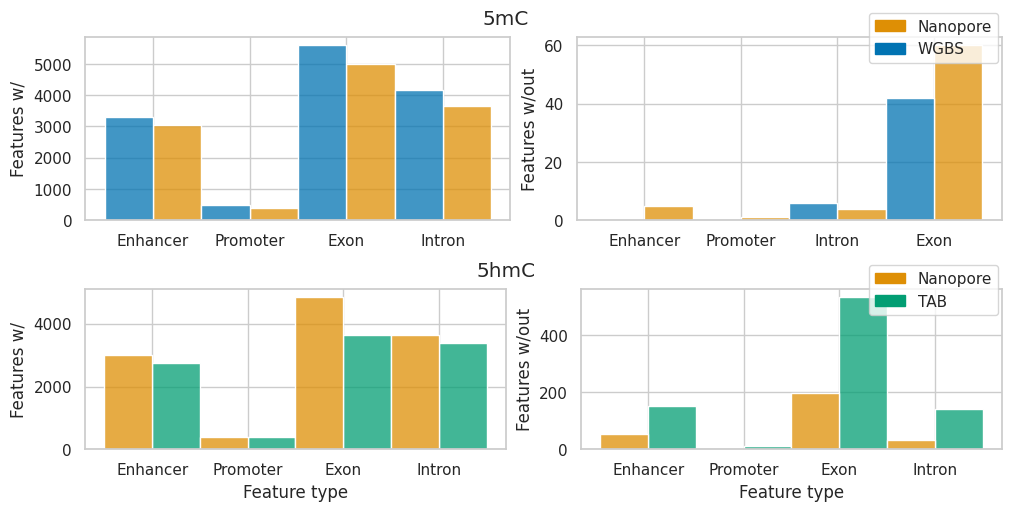

In [8]:
import seaborn as sns
import matplotlib.pyplot as pl
from matplotlib import gridspec

sns.set_theme(style="whitegrid")

fig = pl.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 1, fig)

fig1 = fig.add_subfigure(gs[0, :])
gs1 = gridspec.GridSpec(1, 2, fig1)

ax1 = fig1.add_subplot(gs1[0, 0])
ax2 = fig1.add_subplot(gs1[0, 1])

fig2 = fig.add_subfigure(gs[1, :])
gs2 = gridspec.GridSpec(1, 2, fig2)

ax3 = fig2.add_subplot(gs2[0, 0])
ax4 = fig2.add_subplot(gs2[0, 1])

sns.histplot(mc_averages_df.loc[mc_averages_df["binarised"] == "5mC present"], 
             x="feature_type", hue="method", multiple="dodge", palette=sns.color_palette("colorblind", 2), stat="count", hue_order=("WGBS", "Nanopore"), ax=ax1, legend=None)
sns.histplot(mc_averages_df.loc[mc_averages_df["binarised"] == "5mC absent"], 
             x="feature_type", hue="method", multiple="dodge", palette=sns.color_palette("colorblind", 2), stat="count", hue_order=("WGBS", "Nanopore"), ax=ax2, legend=None)

sns.histplot(hmc_averages_df.loc[hmc_averages_df["binarised"] == "5hmC present"], 
             x="feature_type", hue="method", multiple="dodge", palette=sns.color_palette("colorblind", 3)[1:3], stat="count", hue_order=("Nanopore", "TAB"), ax=ax3, legend=None)
sns.histplot(hmc_averages_df.loc[hmc_averages_df["binarised"] == "5hmC absent"], 
             x="feature_type", hue="method", multiple="dodge", palette=sns.color_palette("colorblind", 3)[1:3], stat="count", hue_order=("Nanopore", "TAB"), ax=ax4, legend=None)

ax1.set_ylabel("Features w/")
ax3.set_ylabel("Features w/")
ax2.set_ylabel("Features w/out")
ax4.set_ylabel("Features w/out")

ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel("Feature type")
ax4.set_xlabel("Feature type")

import matplotlib.patches as mpatches

nano_handle = mpatches.Patch(color=sns.color_palette("colorblind", 3)[1], label='Nanopore')
wgbs_handle = mpatches.Patch(color=sns.color_palette("colorblind", 3)[0], label='WGBS')
tab_handle = mpatches.Patch(color=sns.color_palette("colorblind", 3)[2], label='TAB')

fig1.suptitle("5mC")
fig1.legend(handles=[nano_handle, wgbs_handle])
fig2.suptitle("5hmC")
fig2.legend(handles=[nano_handle, tab_handle])

fig.set_constrained_layout(True)
fig.show()